# Basic Usages of Meep
- Offical Document  
https://meep.readthedocs.io/en/latest/
- Python Examples and Jupyter Notebooks
  - https://github.com/NanoComp/meep
  - https://github.com/NanoComp/meep/tree/master/python/examples

This notebook is a short version fused with `bend-flux.ipynb` from the above link. 

Meep is a free and open-source software package for electromagnetics simulation via the finite-difference time-domain (FDTD) method. 
FDTD is an important EM solver that warrants further understanding.
However, I won’t delve into extensive details about the theory. Instead, the goal of this tutorial is the practical usages. You will learn how to apply it for calculating reflection, transmission, and reflections.  

Reader interested at theories can read
- Finite Difference Time Domain (FDTD)
    - **`Slides`** [A introduction to Meep and FDTD](http://ab-initio.mit.edu/~ardavan/stuff/IEEE_Photonics_Society_SCV3.pdf)
    - **`Books`** [Introduction to the finite-difference time-domain (FDTD) method for electromagnetics](https://ieeexplore.ieee.org/document/6812520)
    - **`Book`** [Advances in FDTD Computational Electrodynamics: Photonics and Nanotechnology](http://ieeexplore.ieee.org/document/9100982)


A FDTD simulation with Meep consists of 
 1. Geometry and materials
     - resolution: how many grids in one micron
     - cell_size: the whole simulation space
     - geometry: materials and their shape
     - pml: perfectly match layers to replace vacuum. scattering BCs
 2. Sources
     - GaussianSource(fcen, fwidth=df)
     - mp.ContinuousSource(frequency=f)
     ```
     sources = [mp.Source(mp.ContinuousSource(frequency=0.15),
                     component=mp.Ez,
                     center=mp.Vector3(-7,0))]
     ```
 3. Simulation
     - set simulation 
     
     ```
     sim = mp.Simulation(
    cell_size=cell,
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=sources,
    resolution=resolution,
    )
       ```
    - add flux monitor: to record energy flux through a surface
    - run simulation
    ```
    sim.run(until_after_sources=mp.stop_when_fields_decayed(50,   mp.Ez, pt, 1e-3))
    ```

## Simulation of a straight waveguide

In [1]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt

resolution = 10  # pixels/um

sx = 24  # size of cell in X direction
sy = 16  # size of cell in Y direction
cell = mp.Vector3(sx, sy, 0)

dpml = 1.0
pml_layers = [mp.PML(dpml)]

In [2]:
w = 1.5
y_loc = -4
geometry = [
    mp.Block(
        size=mp.Vector3(sx, w),
        center=mp.Vector3(0, y_loc),
        material=mp.Medium(epsilon=12),
    )
]

In [3]:
fcen = 0.15  # pulse center frequency
df = 0.1  # pulse width (in frequency)
sources = [
    mp.Source(
        mp.GaussianSource(fcen, fwidth=df),
        component=mp.Ez,
        center=mp.Vector3(-0.5 * sx + dpml, y_loc, 0),
        size=mp.Vector3(0, w, 0),
    )
]

     block, center = (0,-4,0)
          size (24,1.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)


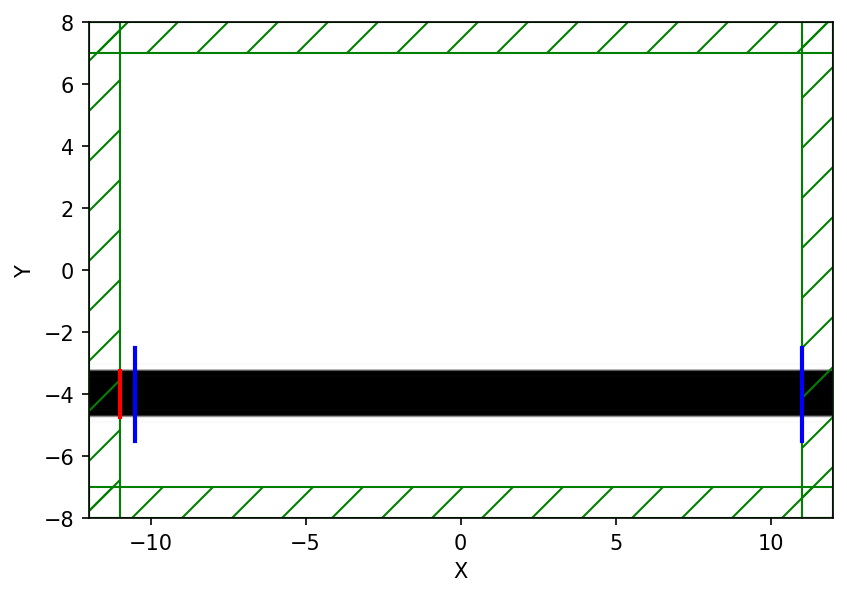

In [4]:
sim = mp.Simulation(
    cell_size=cell,
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=sources,
    resolution=resolution,
)

nfreq = 100  # number of frequencies at which to compute flux

# reflected flux
refl_fr = mp.FluxRegion(
    center=mp.Vector3(-0.5 * sx + dpml + 0.5, y_loc, 0), size=mp.Vector3(0, 2 * w, 0)
)
refl = sim.add_flux(fcen, df, nfreq, refl_fr)

# transmitted flux
tran_fr = mp.FluxRegion(
    center=mp.Vector3(0.5 * sx - dpml, y_loc, 0), size=mp.Vector3(0, 2 * w, 0)
)
tran = sim.add_flux(fcen, df, nfreq, tran_fr)

plt.figure(dpi=150)
sim.plot2D()
plt.show()

In [5]:
pt = mp.Vector3(0.5 * sx - dpml - 0.5, y_loc)

sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ez, pt, 1e-3))

# for normalization run, save flux fields data for reflection plane
straight_refl_data = sim.get_flux_data(refl)
# save incident power for transmission plane
straight_tran_flux = mp.get_fluxes(tran)

-----------
Initializing structure...
time for choose_chunkdivision = 0.00513005 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 10
     block, center = (0,-4,0)
          size (24,1.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.059217 s
-----------
field decay(t = 50.050000000000004): 1.3422270076896456e-10 / 1.3422270076896456e-10 = 1.0
field decay(t = 100.05000000000001): 6.9449087771580845e-06 / 6.9449087771580845e-06 = 1.0
field decay(t = 150.1): 0.03103134355810438 / 0.03103134355810438 = 1.0
field decay(t = 200.15): 0.0003331599234419008 / 0.03103134355810438 = 0.010736239080917599
field decay(t = 250.20000000000002): 1.5289579439176683e-13 / 0.03103134355810438 = 4.927140653948108e-12
run 0 finished at t = 250.20000000000002 (5004 timesteps)


## Simulation of a 90$^\circ$ bend

-----------
Initializing structure...
time for choose_chunkdivision = 0.000238895 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 10
     block, center = (-6,-4,0)
          size (12,1.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0.75,1.625,0)
          size (1.5,12.75,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.049818 s
-----------
field decay(t = 50.050000000000004): 9.076308010359377e-08 / 9.076308010359377e-08 = 1.0
field decay(t = 100.05000000000001): 2.9720505355674203e-06 / 2.9720505355674203e-06 = 1.0
field decay(t = 150.1): 0.00018942194098943327 / 0.00018942194098943327 = 1.0
field decay(t = 200.15): 5.8518580296491934e-05 / 0.00018942194098943327 = 0.3089324287926938
field decay(t = 250.20000000000002): 2.2604624934926072e-11 / 0.00018942194098943327 = 1.1933477619779565e-07
run 0

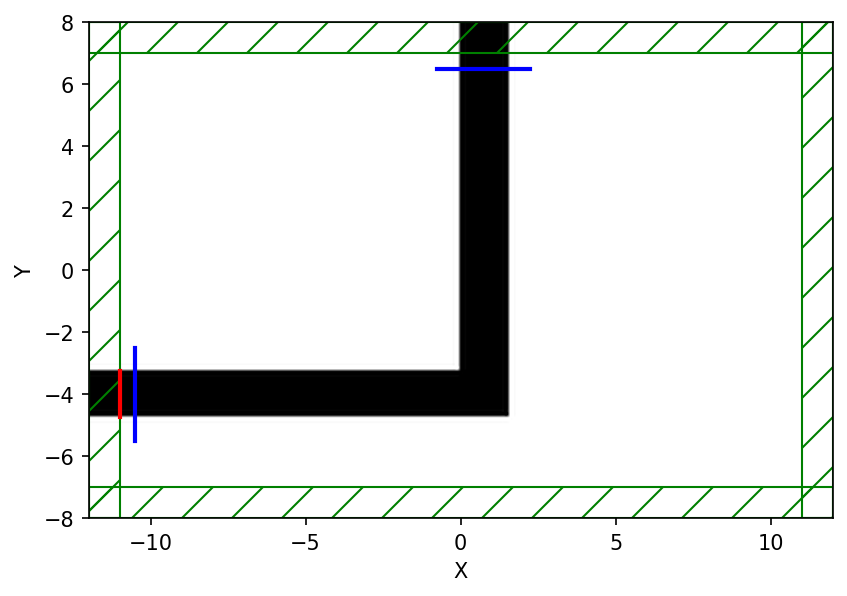

In [6]:

geometry = [
    mp.Block(
        mp.Vector3(sx/2 , w),
        center=mp.Vector3(-sx/4, y_loc),
        material=mp.Medium(epsilon=12),
    ),
    mp.Block(
        mp.Vector3(w, sy/2 - y_loc + w /2),
        center=mp.Vector3( w/2, - y_loc/2 - w/4),
        material=mp.Medium(epsilon=12),
    ),
]

sim_bend = mp.Simulation(
    cell_size=cell,
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=sources,
    resolution=resolution,
)

# reflected flux
refl = sim_bend.add_flux(fcen, df, nfreq, refl_fr)

tran_fr = mp.FluxRegion(
    center = mp.Vector3( w/2, 0.5 * sy - dpml - 0.5), size=mp.Vector3(2 * w, 0, 0)
)
tran = sim_bend.add_flux(fcen, df, nfreq, tran_fr)

# for normal run, load negated fields to subtract incident from refl. fields
sim_bend.load_minus_flux_data(refl, straight_refl_data)

pt = mp.Vector3( w/2, 0.5 * sy - dpml - 0.5)

sim_bend.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ez, pt, 1e-3))

bend_refl_flux = mp.get_fluxes(refl)
bend_tran_flux = mp.get_fluxes(tran)

flux_freqs = mp.get_flux_freqs(refl)

plt.figure(dpi=150)
sim_bend.plot2D()
plt.show()

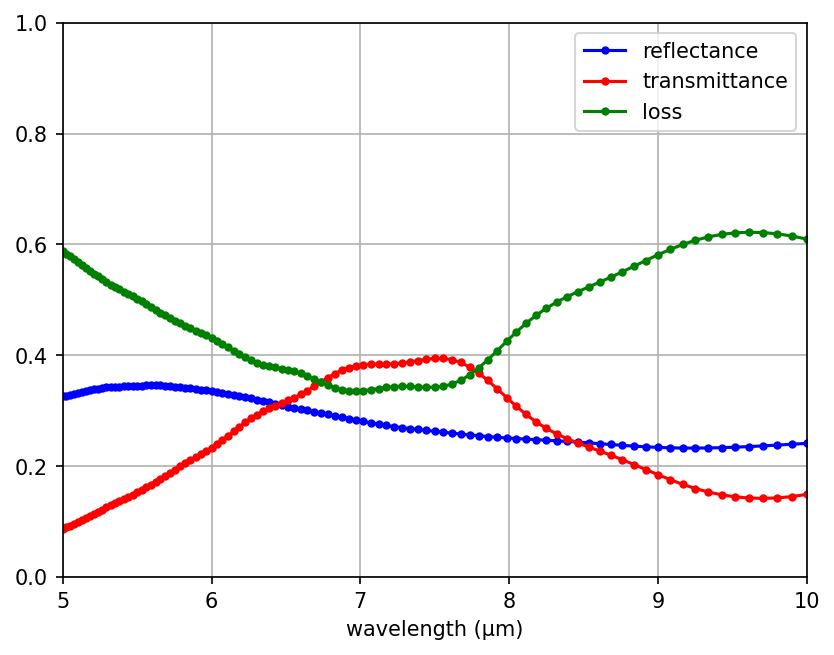

In [7]:
wl = []
Rs = []
Ts = []
for i in range(nfreq):
    wl = np.append(wl, 1 / flux_freqs[i])
    Rs = np.append(Rs, -bend_refl_flux[i] / straight_tran_flux[i])
    Ts = np.append(Ts, bend_tran_flux[i] / straight_tran_flux[i])

if mp.am_master():
    plt.figure(dpi=150)
    plt.plot(wl, Rs, "b.-", label="reflectance")
    plt.plot(wl, Ts, "r.-", label="transmittance")
    plt.plot(wl, 1 - Rs - Ts, "g.-", label="loss")
    plt.axis([5.0, 10.0, 0, 1])
    plt.xlabel("wavelength (μm)")
    plt.legend(loc="upper right")
    plt.grid()
    plt.show()

In [9]:
## rerun simulation, recored plot a every 0.5, and generate movie 
sim_bend.reset_meep()
f = plt.figure(dpi=100)
Animate = mp.Animate2D(fields=mp.Ez, f=f, realtime=False, normalize=True)
plt.close()
sim_bend.run(mp.at_every(0.5, Animate), until=300)
plt.close()
filename = "bend_waveguide.mp4"
Animate.to_mp4(10, filename)

-----------
Initializing structure...
time for choose_chunkdivision = 0.000245094 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 10
     block, center = (-6,-4,0)
          size (12,1.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0.75,1.625,0)
          size (1.5,12.75,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.0543072 s
-----------
     block, center = (-6,-4,0)
          size (12,1.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0.75,1.625,0)
          size (1.5,12.75,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
Normalizing field data...
run 2 finished at t = 300.0 (6000 timesteps)
Generating MP4...
